In [1]:
import sys
import os
import ssm
import pickle

import numpy                   as      np
import pandas                  as      pd

import matplotlib              as      mpl
import matplotlib.pyplot       as      plt
import seaborn                 as      sns

from   einops                  import  rearrange
from   utils                   import  load_data

import statsmodels.api         as      sm
import statsmodels.formula.api as      smf

sns.set_style("white")
#sns.set_context("talk")

### Load data from previous analyses

In [2]:
# load pre-calculated PM data (from 100 random subset)
principal_movements = np.load('outputs/principal_movements_15components.npy')
variance_explained = np.load('outputs/principal_movements_explained_variance_15components.npy')
subject_timeseries = np.load('outputs/principal_movements_timeseries_15components.npy')
subject_norms = np.load('outputs/subject_data_norms.npy')
subject_means = np.load('outputs/subject_data_means.npy')
median_position = np.load('outputs/subject_data_median_position.npy')
# tweak positions
median_position_tweak = median_position.copy()
median_position_tweak[13] = median_position_tweak[13] * 1.3
median_position_tweak[27] = median_position_tweak[27] * 1.2

# load average model
with open('outputs/average-model.pkl', 'rb') as f:
    model = pickle.load(f)

# load model data
data = np.load('outputs/all_model_data.npy')

# get states for each subject
subject_states = [model.most_likely_states(d) for d in data]

# load sub info
_, info = load_data('trajectory_data/')

removing 1 outlier video
removing 1 videos with no age at video


### Principal movements
Movement plots for each principal movement

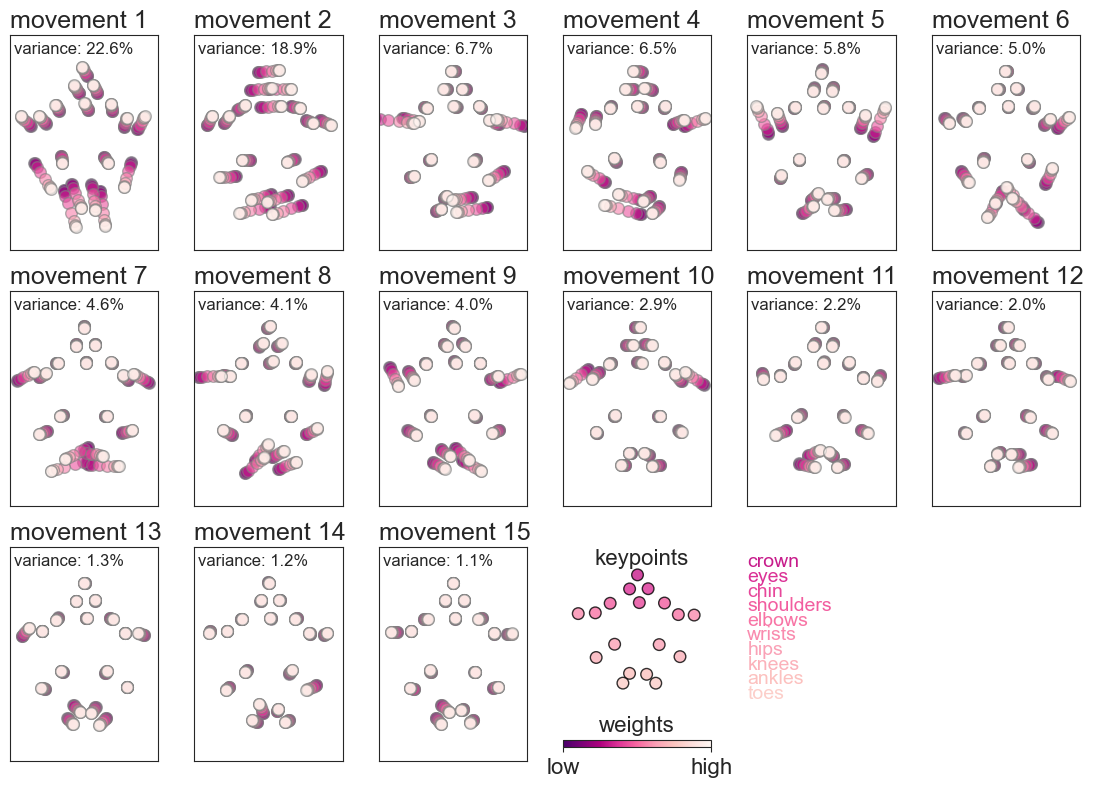

In [3]:
# plot movement range for each principal movement
num_points = 10 # number of points to plot
fig, axs = plt.subplots(3,6, figsize=(11, 8))
axs = axs.reshape(-1)
colors = mpl.colormaps['RdPu_r'].resampled(num_points)

# for each of the PMs
for component in np.arange(15):
    
    # define range of weights
    min_comp = np.percentile(subject_timeseries[:,component], 1)
    max_comp = np.percentile(subject_timeseries[:,component], 99)

    z = 1/(1 + np.exp(-np.linspace(-5,5,num_points))) 
    z = z * (max_comp - min_comp) + min_comp
    z = np.concatenate((z, z[::-1]))

    # reconstruct movements across range of weights
    movement_pattern = z[:,np.newaxis].dot(principal_movements[component,:][np.newaxis,:])
    recon_movement = np.mean(subject_means, axis=0) + (np.mean(subject_norms, axis=0) * movement_pattern) 
    
    # plot movements
    recon_movement = recon_movement[:,:36] + median_position_tweak
    for i in np.arange(num_points):
        axs[component].scatter(recon_movement[i,1::2], -recon_movement[i,::2], 
                               facecolor=colors(i), edgecolor='grey', s=70, alpha=.6)
        axs[component].set_xticklabels([])
        axs[component].set_yticklabels([])
        
    axs[component].set_title('movement {:}'.format(component+1), fontsize=18, loc='left')
    axs[component].text(-52, 90, 'variance: {:.1f}%'.format(variance_explained[component]*100), fontsize=12)
    axs[component].set_xlim(-55, 55)
    axs[component].set_ylim(-130, 110)

# key for median position
lab_colors = mpl.colormaps['RdPu_r'].resampled(20)
lab_color_list = [lab_colors(i-4) for i in (10,11,11,12,13,14,15,16,17,18,19,13,14,15,16,17,18,19)]
axs[-3].scatter(median_position_tweak[1::2], -median_position_tweak[::2], 
                           facecolor=lab_color_list, edgecolor='black', s=70, alpha=.8)
axs[-3].text(-32, 85, 'keypoints', fontsize=16)
axs[-3].set_xlim(-55, 55)
axs[-3].set_ylim(-120, 110)

# add colorbar for PC weights
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='RdPu_r'), ax=axs[-3], orientation='horizontal',
                    ticks=[0, 1], location='bottom', fraction=0.1)
cbar.ax.set_xticklabels(['low', 'high'], fontsize=16) 
cbar.ax.set_xlabel('weights', fontsize=16, labelpad=-45) 

# annotations
for i in [-1, -2, -3]:
    sns.despine(ax=axs[i], left=True, bottom=True)
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
    
axs[-2].set_xlim(-60, 55)
axs[-2].set_ylim(-120, 100)

# keypoint labels
FNT=14
axs[-2].text(-60, 80, 'crown', fontsize=FNT, c=lab_colors(6))
axs[-2].text(-60, 65, 'eyes', fontsize=FNT, c=lab_colors(7))
axs[-2].text(-60, 50, 'chin', fontsize=FNT, c=lab_colors(8))
axs[-2].text(-60, 35, 'shoulders', fontsize=FNT, c=lab_colors(9))
axs[-2].text(-60, 20, 'elbows', fontsize=FNT, c=lab_colors(10))
axs[-2].text(-60, 5, 'wrists', fontsize=FNT, c=lab_colors(11))
axs[-2].text(-60, -10, 'hips', fontsize=FNT, c=lab_colors(12))
axs[-2].text(-60, -25, 'knees', fontsize=FNT, c=lab_colors(13))
axs[-2].text(-60, -40, 'ankles', fontsize=FNT, c=lab_colors(14))
axs[-2].text(-60, -55, 'toes', fontsize=FNT, c=lab_colors(15))


plt.tight_layout()
plt.savefig('figures/principal-movements.png', dpi=300)

### Model samples
Plot to compare empirical data vs synthetic data samples drawn from model

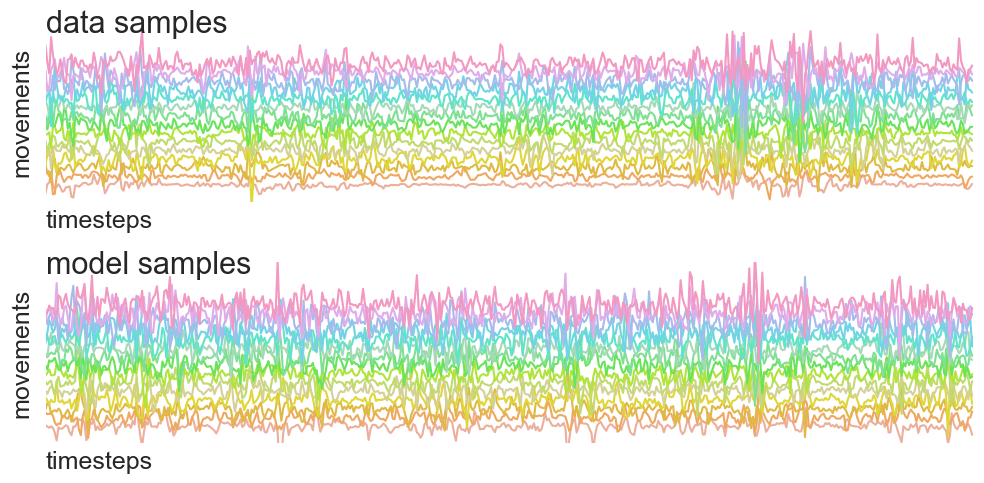

In [13]:
palette=["#ecaf9b",
        "#efa862",
        "#e0b944",
        "#dfd637",
        "#d4d196",
        "#c1da6e",
        "#afe43a",
        "#69e35a",
        "#7de093",
        "#a6d9b7",
        "#60e4c9",
        "#72d3e6",
        "#a5bbec",
        "#e0acea",
        "#f298c1"]


# get model samples from fitted model
synthetic_samples = model.sample(1899)[1][100:]

# get shape values from data
num_subjects, num_timepoints, num_features = np.shape(data)

# plot
fig, axs = plt.subplots(2, 1, figsize=(10,5), sharex=False, sharey=True)

# choose random subect
rand_idx = np.random.choice(np.arange(np.shape(data)[0]), size=1)

# plot principal movement weights
sns.lineplot(np.arange(num_features)+np.squeeze(data[rand_idx])[:500,:], lw=1.5, dashes=False, ax=axs[0], legend=False, palette=palette)
axs[0].set_ylim(-2,19)

# plot synthetic sample weights from fitted model
sns.lineplot((np.arange(num_features)+synthetic_samples)[:500,:], lw=1.5, dashes=False, ax=axs[1], legend=False, palette=palette)

# set titles
axs[0].set_title('data samples', fontsize=22, loc='left', pad=-8)
axs[1].set_title('model samples', fontsize=22, loc='left', pad=-8)

# labels
for ax in axs:
    ax.set_ylim(-2,19)
    ax.set_xlim(0,500)
    ax.set_xlabel('timesteps', fontsize=18, loc='left', labelpad=-4.5)
    ax.set_ylabel('movements', fontsize=18, labelpad=-0.5)
    ax.set_yticklabels([])
    ax.set_xticklabels([])


sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.savefig('figures/model-samples.png'.format(f), transparent=False, dpi=300)


### Feature distributions
Distribution of values for each movement feature in empirical data and synthetic samples

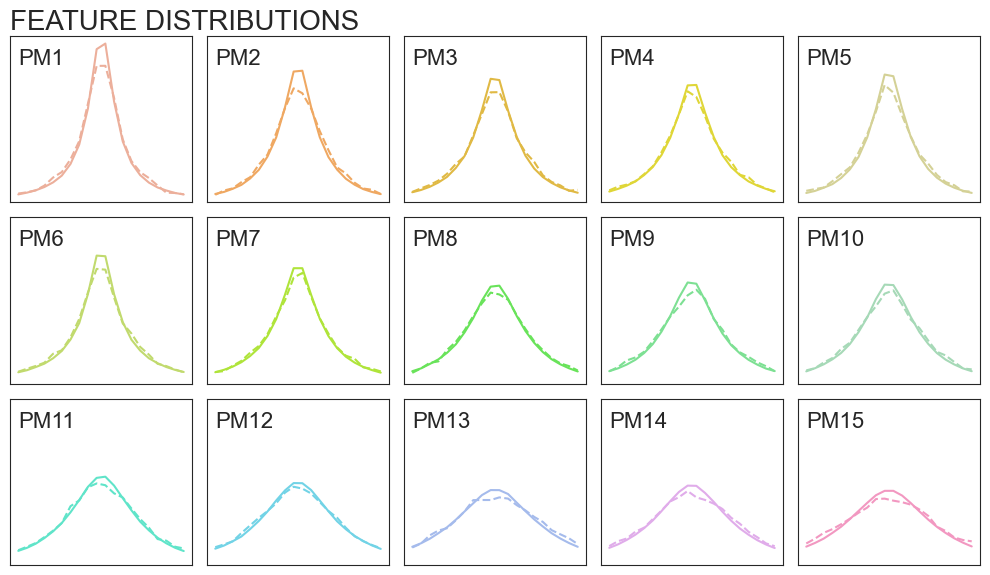

In [5]:
# flatten data
all_data = rearrange(data, 's t f -> (s t) f')

# get model samples (large number to estimate distributions)
synthetic_samples = model.sample(10000)[1]

# distribution of values for each feature (principal movement)
fig, axs = plt.subplots(3, 5, figsize=(10, 6), sharey=True)
axs = axs.reshape(-1)
num_bins = 20

# for each movement
for i in range(num_features):
    
    # plot histograms of PM weights for synthetic and empirical data
    synth_hist = (np.histogram(synthetic_samples[:, i], bins=num_bins, range=(np.percentile(synthetic_samples,5), np.percentile(synthetic_samples, 95)), density=True)[0])
    empirical_hist = (np.histogram(all_data[:, i], bins=num_bins, range=(np.percentile(synthetic_samples,5), np.percentile(synthetic_samples, 95)), density=True)[0])

    axs[i].plot(synth_hist, color=palette[i],
            linewidth=1.5, linestyle='--')
    
    axs[i].plot(empirical_hist, color=palette[i],
        linewidth=1.5)

    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
    axs[i].text(0.05, 1.0, 'PM{:}'.format(i+1), fontsize=16)

# titles
plt.suptitle('FEATURE DISTRIBUTIONS', horizontalalignment='center', x=0.19, y=.95, fontsize=20)
plt.tight_layout()
plt.savefig('figures/model-feature-distributions.png', transparent=False, dpi=300)


### State differences
Plots of movement data in each subject overlaid with most likely state. Top row shows the mostlikely state (top) and movement amplitudes (bottom) for each frame. Middle row shows frames ordered by state. Bottom row shows state occupancy. Each column is a different subject.

/tmp/ipykernel_7406/1744261869.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


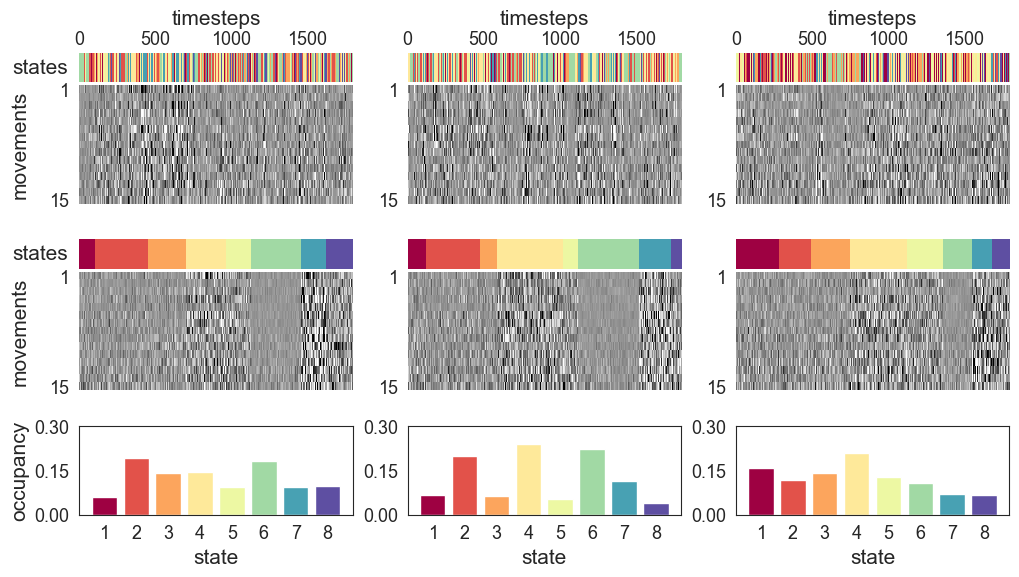

In [6]:
FNT=15
fig, ax = plt.subplots(7, 3, figsize=(12,6), gridspec_kw=dict(height_ratios=[1, 4, 1, 1, 4, 1, 3], hspace=0.05))
ax = ax.reshape(-1)
colors = [plt.get_cmap('Spectral', 8)(i) for i in np.arange(8)]

# subect 1 - 
sub = 0
# state sequence
ss = subject_states[sub]
# movement data (normalise for display)
sdata = ((data[sub] - np.mean(data[sub]))/np.std(data[sub])).T
# count frames in each state
svalues, scounts = np.unique(ss, return_counts=True)
scounts = scounts / sum(scounts)

ax[0].matshow(ss[np.newaxis,:], aspect='auto', cmap='Spectral')
ax[3].matshow(sdata,  aspect='auto',cmap='Greys',vmin=-3, vmax=3)
ax[9].matshow(ss[np.argsort(ss)][np.newaxis, :], aspect='auto', cmap='Spectral',)
ax[12].matshow(sdata[:,np.argsort(ss)], aspect='auto',cmap='Greys',vmin=-3, vmax=3)
ax[18].bar(svalues, scounts, color=colors)

# subect 2
# as above
sub = 1
ss = model.most_likely_states(data[sub])
sdata = ((data[sub] - np.mean(data[sub]))/np.std(data[sub])).T
svalues, scounts = np.unique(ss, return_counts=True)
scounts = scounts / sum(scounts)

ax[1].matshow(ss[np.newaxis,:], aspect='auto', cmap='Spectral')
ax[4].matshow(data[1].T,  aspect='auto',cmap='Greys',vmin=-3, vmax=3)
ax[10].matshow(ss[np.argsort(ss)][np.newaxis, :], aspect='auto', cmap='Spectral')
ax[13].matshow(data[1].T[:,np.argsort(ss)], aspect='auto',cmap='Greys',vmin=-3, vmax=3)
ax[19].bar(svalues, scounts, color=colors)

# subect 3
# as above
sub = 2
ss = model.most_likely_states(data[sub])
sdata = ((data[sub] - np.mean(data[sub]))/np.std(data[sub])).T
svalues, scounts = np.unique(ss, return_counts=True)
scounts = scounts / sum(scounts)

ax[2].matshow(ss[np.newaxis,:], aspect='auto', cmap='Spectral')
ax[5].matshow(data[2].T,  aspect='auto',cmap='Greys', vmin=-3, vmax=3)
ax[11].matshow(ss[np.argsort(ss)][np.newaxis, :], aspect='auto', cmap='Spectral')
ax[14].matshow(data[2].T[:,np.argsort(ss)], aspect='auto',cmap='Greys',vmin=-3, vmax=3)
ax[20].bar(svalues, scounts, color=colors)

# LABELS
ax[0].set_ylabel('states', rotation=0, labelpad=21, va='center', fontsize=FNT) 
ax[3].set_ylabel('movements', labelpad=14, fontsize=FNT)    
ax[9].set_ylabel('states', rotation=0, labelpad=21, va='center', fontsize=FNT)
ax[12].set_ylabel('movements', labelpad=14, fontsize=FNT)    

for axs in ax[:3]:
    axs.tick_params(axis='x', length=0)
    axs.set_xlabel('timesteps', fontsize=FNT)
    axs.xaxis.set_label_position('top') 
    axs.set_xticks((0, 500, 1000, 1500))
    axs.tick_params(axis='x', labelsize=FNT-2)
    axs.set_yticklabels([])
    
for axs in ax[6:12]:
    axs.set_yticklabels([])

for axs in ax[3:15]:
    axs.tick_params(axis='x', length=0)
    axs.set_xticklabels([])    

for axs in ax[3:6]:
    axs.set_yticks((0, 14))
    axs.set_yticklabels([1, 15], fontsize=FNT-2)    
    
for axs in ax[12:15]:
    axs.set_yticks((0, 14))
    axs.set_yticklabels([1, 15], fontsize=FNT-2)  

for axs in ax[15:18]:
    axs.tick_params(axis='both', length=0)
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    
for axs in ax[18:]:
    axs.set_ylim(0,.3)
    axs.set_yticks((0, 0.15, 0.3))
    axs.tick_params(axis='y', labelsize=FNT-2)
    axs.set_xticks(np.arange(8))
    axs.set_xticklabels(np.arange(8)+1, fontsize=FNT-2)
    axs.set_xlabel('state', fontsize=FNT)

for axs in ax[:18]:
    sns.despine(ax=axs, left=True, bottom=True)

ax[18].set_ylabel('occupancy', fontsize=FNT)

plt.tight_layout()
plt.savefig('figures/subject-state-occupancy.png', dpi=300, transparent=False)

### Average state occupancy
the frequency of state occupancy over all subjects

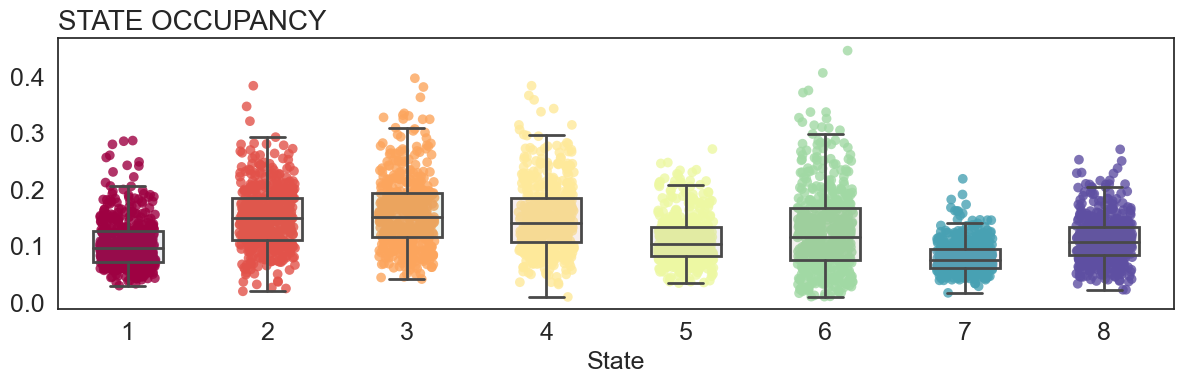

In [7]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
fig, ax = plt.subplots(1, 1, figsize=(12,4))

# count the frequency of each state
svalues = []
scounts = []
for s in subject_states:
    v, c = np.unique(s, return_counts=True)
    svalues.append(v)
    scounts.append(c/sum(c))
    
# plot
b = sns.boxplot(x=np.stack(svalues).reshape(-1)+1, y=np.stack(scounts).reshape(-1), linewidth=2, width = 0.5, fliersize=0)
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .1))   
    
sns.stripplot(x=np.stack(svalues).reshape(-1), y=np.stack(scounts).reshape(-1), 
              native_scale=True, hue=np.stack(svalues).reshape(-1), zorder=0,
              s=7, palette=colors, alpha=0.8, jitter=0.2, linewidth=0, edgecolor='grey' ,legend=False)

# labels
ax.set_title('STATE OCCUPANCY', fontsize=20, loc='left')
ax.set_xlabel('State', fontsize=18)
ax.tick_params(axis='both', labelsize=18)

plt.tight_layout()
plt.savefig('figures/average-state-occupancy.png', dpi=300, transparent=False)

### Changes in state occupancy over time
For each subject, state occupancy (# frames in each state) is plotted against age, videos in the same subject are joined byy a line

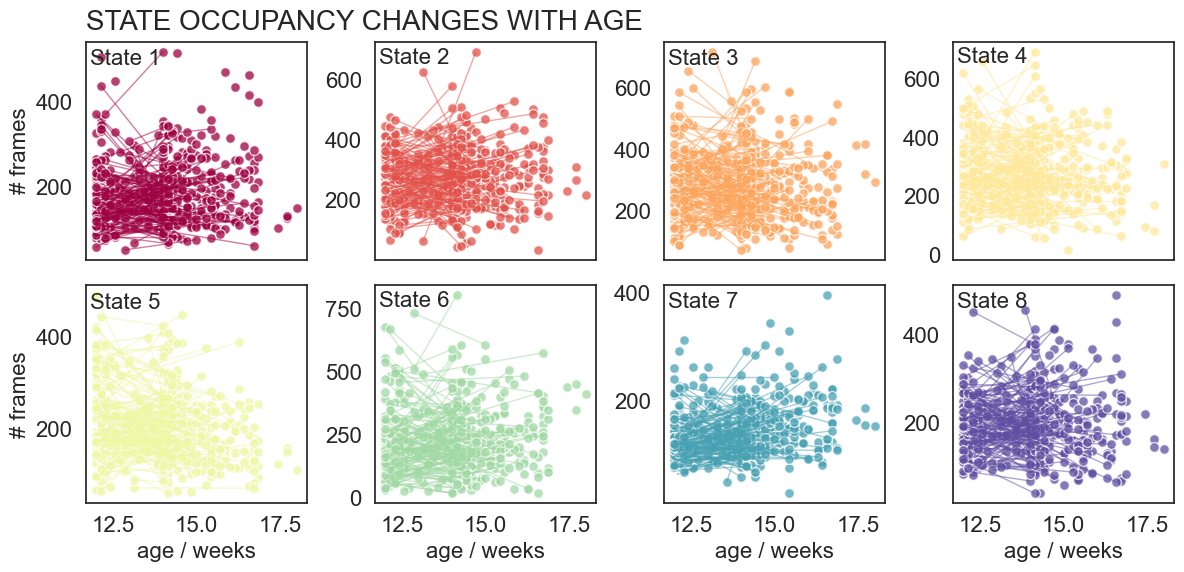

In [8]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# get age
ages = info.age_at_vid.values
# reset index to account for the excluded videos
reset_info = info.reset_index()

# specify the number of states
num_states = 8

# create the subplots
fig, axs = plt.subplots(2, 4, sharex=True, sharey=False, figsize=(12, 6))

# plots
all_counts = []
for s in range(num_states):
    # count the occurrences of the state in each subject
    counts = [sum(state == s for state in subject_states[i]) if any(state == s for state in subject_states[i]) else 0 for i in range(len(ages))]
    # keep counts for all states
    all_counts.append(counts)
    # scatter plot
    axs[s//4][s%4].scatter(ages, counts, color=colors[s], s=50, edgecolor='white', alpha=0.75)
    axs[s//4][s%4].tick_params(axis='both', labelsize=16)
    
    # join repeated videos with a line
    for idx in reset_info['participant'].unique():
        df_idx = reset_info[reset_info['participant'] == idx].index.values
        axs[s//4][s%4].plot([ages[d] for d in df_idx], [counts[d] for d in df_idx], lw=1, alpha=.5, color=colors[s])

# labels
for s in range(num_states):
    x_loc = axs[s//4][s%4].get_xlim()[0]
    x_loc = x_loc + x_loc * .01
    y_loc = axs[s//4][s%4].get_ylim()[1]
    y_loc = y_loc - y_loc * .1
    axs[s//4][s%4].text(x_loc, y_loc , 'State {:}'.format(s+1), fontsize=16)

for ax in axs[1]:    
    ax.set_xlabel('age / weeks', fontsize=16)
axs[0][0].set_ylabel('# frames', fontsize=16)
axs[1][0].set_ylabel('# frames', fontsize=16)

plt.suptitle('STATE OCCUPANCY CHANGES WITH AGE', horizontalalignment='center', x=0.31, y=.95, fontsize=20)

plt.tight_layout()
plt.savefig('figures/state-occupancy-by-age.png', dpi=300, transparent=False)

### Statistics
Test associations between state occupancy and age using linear mixed effects models

In [9]:
all_counts = pd.DataFrame(np.stack(all_counts).T)
all_counts.columns = ['state{:}'.format(i+1) for i in np.arange(8)]

state_info = pd.concat((reset_info, all_counts), axis=1)
state_info

,index,idnum,participant,timepoint,group,final_gma,gma_vid_cat,gma_vid_score,cp_diagnosis_2year,gmfcs,...,age_at_vid,video,state1,state2,state3,state4,state5,state6,state7,state8
0,0,2,162003,14,preterm,normal GM,continous,normal GM,No CP,0.0,...,14.857142,162003_2,107,343,252,260,167,327,167,176
1,1,8,162009,14,preterm,normal GM,continous,normal GM,NaN,NaN,...,15.428572,162009_2,119,357,111,433,98,400,207,74
2,2,16,162017,12,preterm,normal GM,continous,normal GM,No CP,0.0,...,12.428572,162017_1,284,211,256,373,232,193,129,121
3,3,21,162022,14,preterm,normal GM,continous,normal GM,No CP,0.0,...,16.000000,162022_2,152,171,418,203,217,278,149,211
4,4,22,162023,12,preterm,normal GM,continous,normal GM,No CP,0.0,...,13.714286,162023_1,224,376,239,310,346,72,99,133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,483,574,167212,12,term control,normal GM,continous,normal GM,No CP,0.0,...,12.857142,167212_1,54,192,134,200,148,733,245,93
482,484,574,167212,14,term control,normal GM,intermittent,normal GM,No CP,0.0,...,15.000000,167212_2,78,201,239,206,109,608,245,113
483,485,577,167215,12,term control,normal GM,continous,normal GM,No CP,0.0,...,12.000000,167215_1,372,160,383,142,353,42,121,226
484,486,577,167215,14,term control,normal GM,continous,normal GM,No CP,0.0,...,14.142858,167215_2,184,346,306,232,268,142,135,186


In [10]:
fitted_models = []

for state in all_counts.columns:
    age_model = smf.mixedlm('{:} ~ age_at_vid'.format(state), state_info, groups=state_info["participant"])

    age_model_fit = age_model.fit()
    print('')
    print('Model results: {:}'.format(state))
    print(age_model_fit.summary())
    fitted_models.append(age_model_fit)

    
# gather results
pvals = [m.pvalues[:2] for m in fitted_models]
coef = [m.params[:2] for m in fitted_models]
se = [m.bse[:2] for m in fitted_models]

# dataframes
coef = pd.DataFrame(coef)
coef = coef.melt(value_name='coef', var_name='modelterm')

se = pd.DataFrame(se)
se = se.melt(value_name='se', var_name='modelterm')

pvals = pd.DataFrame(pvals)
pvals = pvals.melt(value_name='pvals', var_name='modelterm')

states = pd.DataFrame(np.tile(np.arange(8)+1, 2))
states.columns = ['state']

model_results = pd.concat((states, coef, se, pvals), axis=1)
model_results = model_results.loc[:,~model_results.columns.duplicated()].copy()
model_results = model_results.sort_values(by='state').reset_index(drop=True)

# save out
model_results.to_csv('outputs/age-model-results.csv', index=None)
with open('outputs/age-mixed-models.pkl', 'wb') as fp:
    pickle.dump(fitted_models, fp)


Model results: state1
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: state1    
No. Observations: 486     Method:             REML      
No. Groups:       330     Scale:              3162.1293 
Min. group size:  1       Log-Likelihood:     -2785.0956
Max. group size:  2       Converged:          Yes       
Mean group size:  1.5                                   
--------------------------------------------------------
             Coef.   Std.Err.   z   P>|z| [0.025  0.975]
--------------------------------------------------------
Intercept    125.293   30.345 4.129 0.000 65.817 184.769
age_at_vid     4.712    2.144 2.198 0.028  0.510   8.914
Group Var   3036.156   14.439                           


Model results: state2
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: state2    
No. Observations: 486     Method:             REML      
No. Groups:       330     Scale:              6035.8163 
Min.

### Age effects with stats overlaid

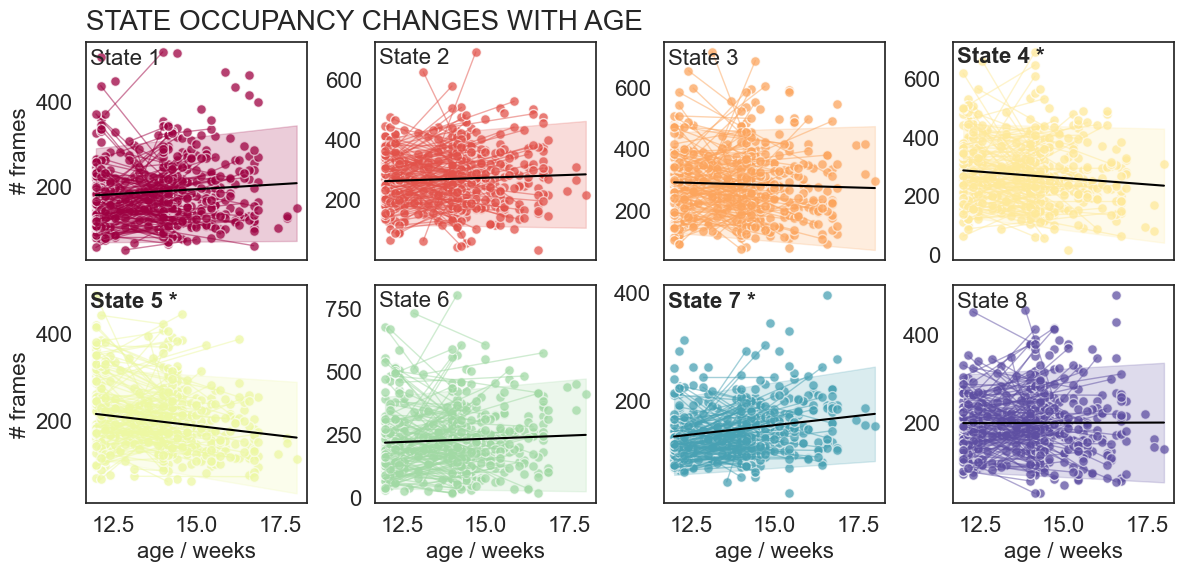

In [11]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# get age
ages = info.age_at_vid.values
# reset index to account for the excluded videos
reset_info = info.reset_index()

# specify the number of states
num_states = 8

# create the subplots
fig, axs = plt.subplots(2, 4, sharex=True, sharey=False, figsize=(12, 6))

# dummy data
age=np.linspace(min(ages), max(ages), 50)
group = ['162003'] * 50 # ignore in mode predictions
# dummy df for predictions
newx = pd.DataFrame((age, group)).T
newx.columns = ['age_at_vid', 'participant']
newx = newx.astype(dtype= {'age_at_vid':'float64',
                           'participant':'int64'})

# plots
for s in range(num_states):
    # count the occurrences of the state in each subject
    counts = [sum(state == s for state in subject_states[i]) if any(state == s for state in subject_states[i]) else 0 for i in range(len(ages))]

    # scatter plot
    axs[s//4][s%4].scatter(ages, counts, color=colors[s], s=50, edgecolor='white', alpha=0.75)
    axs[s//4][s%4].tick_params(axis='both', labelsize=16)
    
    # join repeated videos with a line
    for idx in reset_info['participant'].unique():
        df_idx = reset_info[reset_info['participant'] == idx].index.values
        axs[s//4][s%4].plot([ages[d] for d in df_idx], [counts[d] for d in df_idx], lw=1, alpha=.5, color=colors[s])

    # calculate model predictions and intervals
    predictions = fitted_models[s].predict(newx)
    lower = newx['age_at_vid'] * fitted_models[s].conf_int()[0]['age_at_vid'] + fitted_models[s].conf_int()[0]['Intercept'] 
    upper = newx['age_at_vid'] * fitted_models[s].conf_int()[1]['age_at_vid'] + fitted_models[s].conf_int()[1]['Intercept'] 

    axs[s//4][s%4].plot(newx['age_at_vid'], predictions, color='black')
    axs[s//4][s%4].fill_between(newx['age_at_vid'], lower, upper, edgecolor=None, color=colors[s], alpha=0.2)

# labels
for s in range(num_states):
    x_loc = axs[s//4][s%4].get_xlim()[0]
    x_loc = x_loc + x_loc * .01
    y_loc = axs[s//4][s%4].get_ylim()[1]
    y_loc = y_loc - y_loc * .1
    if fitted_models[s].pvalues['age_at_vid']<(0.05/8):
        axs[s//4][s%4].text(x_loc, y_loc , 'State {:} *'.format(s+1), fontsize=16, fontweight='bold')
    else:
        axs[s//4][s%4].text(x_loc, y_loc , 'State {:}'.format(s+1), fontsize=16)


for ax in axs[1]:    
    ax.set_xlabel('age / weeks', fontsize=16)
axs[0][0].set_ylabel('# frames', fontsize=16)
axs[1][0].set_ylabel('# frames', fontsize=16)

plt.suptitle('STATE OCCUPANCY CHANGES WITH AGE', horizontalalignment='center', x=0.31, y=.95, fontsize=20)

plt.tight_layout()
plt.savefig('figures/state-occupancy-by-age-with-stats.png', dpi=300, transparent=False)

### Additional stats models
State occupancy tested for assocations with birth status (preterm/term) and GMA outcome

y ~ group + GMA + age

In [12]:
fitted_models = []

outcome_info = state_info[~pd.isna(state_info['final_gma'])]

for state in all_counts.columns:
    all_model = smf.mixedlm('{:} ~ C(group) + age_at_vid + final_gma'.format(state), outcome_info, groups=outcome_info["participant"])

    all_model_fit = all_model.fit()
    print('')
    print('Model results: {:}'.format(state))
    print(all_model_fit.summary())
    fitted_models.append(all_model_fit)



Model results: state1
                 Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      state1    
No. Observations:      482          Method:                  REML      
No. Groups:            326          Scale:                   3176.3379 
Min. group size:       1            Log-Likelihood:          -2750.2383
Max. group size:       2            Converged:               Yes       
Mean group size:       1.5                                             
-----------------------------------------------------------------------
                          Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------
Intercept                 116.477   32.402  3.595 0.000  52.970 179.985
C(group)[T.term control]   27.351    8.345  3.278 0.001  10.996  43.706
final_gma[T.normal GM]     -6.609   12.932 -0.511 0.609 -31.955  18.737
age_at_vid                  4.751    2.179  2.180 0.029   


Model results: state8
                 Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      state8    
No. Observations:      482          Method:                  REML      
No. Groups:            326          Scale:                   3498.6640 
Min. group size:       1            Log-Likelihood:          -2730.2958
Max. group size:       2            Converged:               Yes       
Mean group size:       1.5                                             
-----------------------------------------------------------------------
                          Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------
Intercept                 194.007   31.962  6.070 0.000 131.363 256.651
C(group)[T.term control]   33.600    7.637  4.400 0.000  18.632  48.569
final_gma[T.normal GM]    -11.568   11.797 -0.981 0.327 -34.689  11.553
age_at_vid                 -0.080    2.178 -0.037 0.971  -

Accounting for changes with age, there are significant differences in the amount of time preterm and term infants spend in different states  
GMA outcome is associated with time spent in state 7